In [10]:
# Pipeline for combining all np.sum calculations for ePix Runs 14-17
# Last ran 07/21/2025

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
# Runs and file paths
runs = [14, 15, 16, 17]
file_template = "/sdf/group/rfar/timodo/ePix_Runs_ErrorPlot_Data/part0_run_{}.npz"

# Plot colors and labels
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels = [f'Run-{r}' for r in runs]

In [13]:
# Helper function to compute mean and std at each unique time point
def compute_errorbars_by_time(time, com):
    unique_times = np.unique(time)
    means = []
    stds = []
    for ut in unique_times:
        vals = com[time == ut]
        means.append(np.mean(vals))
        stds.append(np.std(vals))
    return unique_times, np.array(means), np.array(stds)

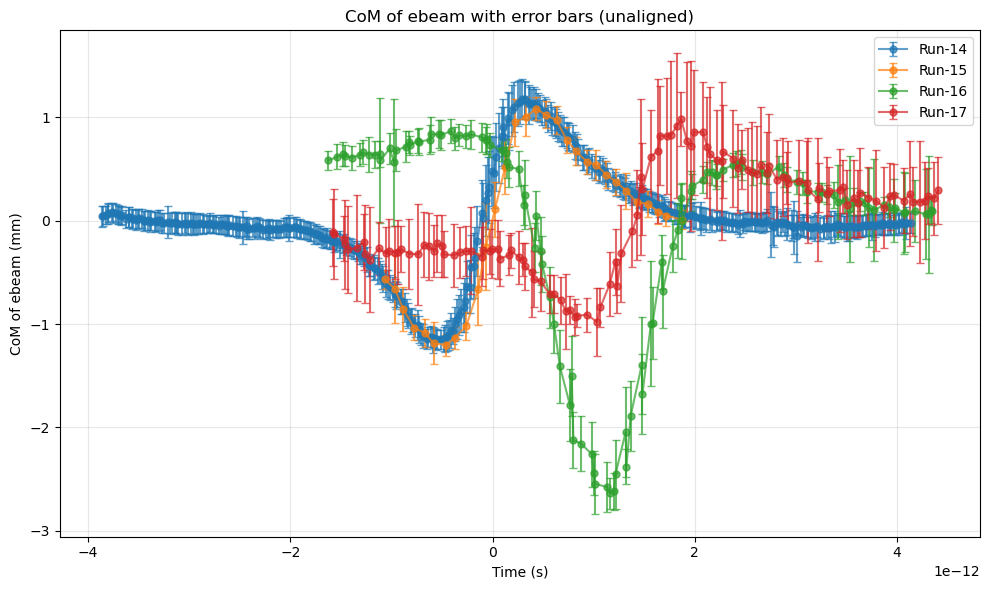

In [14]:
plt.figure(figsize=(10, 6))

for i, run in enumerate(runs):
    data = np.load(file_template.format(run))
    time = data['t_part']
    com = data['img_com_2_part_100um']
    
    uniq_t, mean_vals, std_vals = compute_errorbars_by_time(time, com)

    plt.errorbar(uniq_t, mean_vals, yerr=std_vals, fmt='o-', capsize=3,
                 color=colors[i], label=labels[i], alpha=0.7, markersize=5)

plt.xlabel('Time (s)')
plt.ylabel('CoM of ebeam (mm)')
plt.title('CoM of ebeam with error bars (unaligned)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

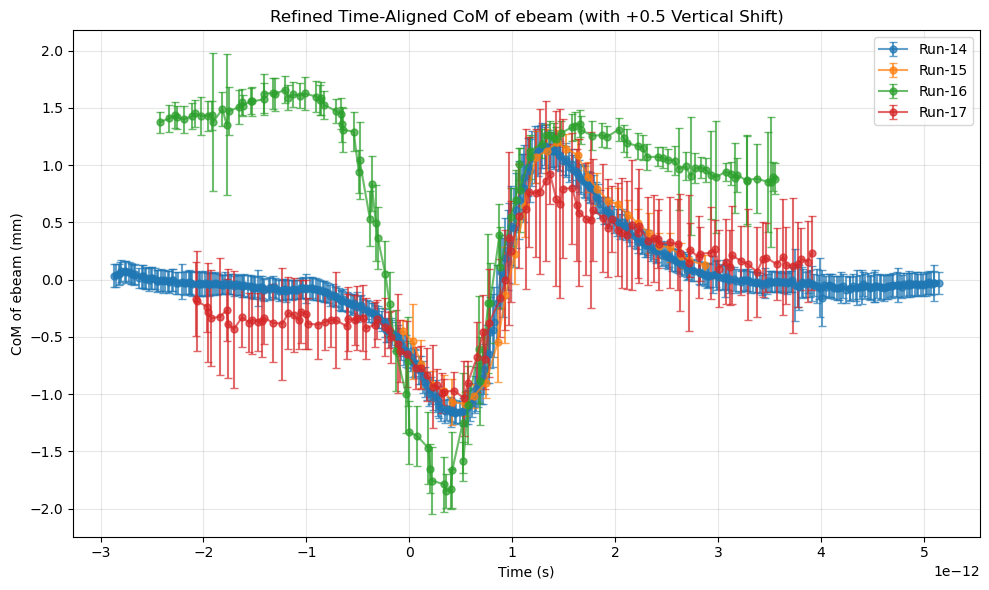

In [15]:
# Function to compute error bars (reuse your version)
def compute_errorbars_by_time(time, values):
    uniq_t = np.unique(time)
    mean_vals = np.array([values[time==t].mean() for t in uniq_t])
    std_vals = np.array([values[time==t].std() for t in uniq_t])
    return uniq_t, mean_vals, std_vals

plt.figure(figsize=(10, 6))

# Refined time shifts for better alignment (in seconds)
time_shifts = {
    14: 1.0e-12,
    15: 1.0e-12,
    16: -0.8e-12,
    17: -0.5e-12,
}

# Reference runs for vertical alignment (already aligned)
reference_runs = [22, 23, 25]
reference_means = []
align_start, align_end = 0, 2e-12

# Compute vertical alignment target mean
for run in reference_runs:
    data = np.load(file_template.format(run))
    time = data['t_part']
    com = data['img_com_2_part_100um']
    mask = (time >= align_start) & (time <= align_end)
    reference_means.append(np.mean(com[mask]))

target_mean = np.mean(reference_means)

# Plot each run with both time/vertical alignment AND extra vertical offset (+0.5)
for i, run in enumerate(runs):
    data = np.load(file_template.format(run))
    time = data['t_part']
    com = data['img_com_2_part_100um']

    uniq_t, mean_vals, std_vals = compute_errorbars_by_time(time, com)

    # Apply time shift
    t_shift = time_shifts.get(run, 0.0)
    shifted_t = uniq_t + t_shift

    # Apply vertical shift
    mask = (shifted_t >= align_start) & (shifted_t <= align_end)
    current_mean = np.mean(mean_vals[mask])
    v_shift = target_mean - current_mean
    aligned_vals = mean_vals + v_shift

    # Apply additional vertical shift so all curves start near zero
    aligned_vals += 0.6

    # Plot with error bars
    plt.errorbar(shifted_t, aligned_vals, yerr=std_vals, fmt='o-', capsize=3,
                 color=colors[i], label=labels[i], alpha=0.7, markersize=5)

plt.xlabel('Time (s)')
plt.ylabel('CoM of ebeam (mm)')
plt.title('Refined Time-Aligned CoM of ebeam (with +0.5 Vertical Shift)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
# Find time difference between peak (max) and trough (min) for each curve
peak_trough_times = []

for i, run in enumerate(runs):
    data = np.load(file_template.format(run))
    time = data['t_part']
    com = data['img_com_2_part_100um']
    uniq_t, mean_vals, std_vals = compute_errorbars_by_time(time, com)

    # Apply time shift
    t_shift = time_shifts.get(run, 0.0)
    shifted_t = uniq_t + t_shift

    # Apply vertical shift
    # Use same align window as previously used
    mask = (shifted_t >= align_start) & (shifted_t <= align_end)
    current_mean = np.mean(mean_vals[mask])
    aligned_vals = mean_vals + target_mean - current_mean

    peak_idx = np.argmax(aligned_vals)
    trough_idx = np.argmin(aligned_vals)
    peak_time = shifted_t[peak_idx]
    trough_time = shifted_t[trough_idx]
    delta_t = peak_time - trough_time   # seconds

    peak_trough_times.append((run, peak_time, trough_time, delta_t))
    print(f"Run-{run}: Peak at {peak_time:.3e}s, Trough at {trough_time:.3e}s, Δt = {delta_t:.3e}s")

Run-14: Peak at 1.317e-12s, Trough at 4.417e-13s, Δt = 8.750e-13s
Run-15: Peak at 1.433e-12s, Trough at 5.417e-13s, Δt = 8.917e-13s
Run-16: Peak at -1.208e-12s, Trough at 3.583e-13s, Δt = -1.567e-12s
Run-17: Peak at 1.367e-12s, Trough at 5.333e-13s, Δt = 8.333e-13s


In [17]:
# Slope of CoM vs. time in μm/fs for each curve (aligned)
slope_results = []

for i, run in enumerate(runs):
    data = np.load(file_template.format(run))
    time = data['t_part']
    com = data['img_com_2_part_100um']
    uniq_t, mean_vals, std_vals = compute_errorbars_by_time(time, com)

    # Apply time shift
    t_shift = time_shifts.get(run, 0.0)
    shifted_t = uniq_t + t_shift

    # Apply vertical shift for alignment
    mask = (shifted_t >= align_start) & (shifted_t <= align_end)
    current_mean = np.mean(mean_vals[mask])
    aligned_vals = mean_vals + target_mean - current_mean

    # Convert x (time) axis from seconds to femtoseconds
    t_fs = shifted_t * 1e15
    # Convert y (CoM) from mm to μm
    y_um = aligned_vals * 1e3

    # Linear fit (μm/fs)
    slope, intercept = np.polyfit(t_fs, y_um, deg=1)
    slope_results.append((run, slope))
    print(f"Run-{run}: Slope = {slope:.3e} μm/fs")

Run-14: Slope = 3.128e-02 μm/fs
Run-15: Slope = 5.343e-01 μm/fs
Run-16: Slope = -6.928e-02 μm/fs
Run-17: Slope = 1.637e-01 μm/fs


In [18]:
# Store results
peak_trough_times = []
slope_results = []

for i, run in enumerate(runs):
    data = np.load(file_template.format(run))
    time = data['t_part']
    com = data['img_com_2_part_100um']
    uniq_t, mean_vals, std_vals = compute_errorbars_by_time(time, com)

    # Apply time shift for alignment
    t_shift = time_shifts.get(run, 0.0)
    shifted_t = uniq_t + t_shift

    # Apply vertical alignment (same as used in previous plots)
    mask = (shifted_t >= align_start) & (shifted_t <= align_end)
    current_mean = np.mean(mean_vals[mask])
    v_shift = target_mean - current_mean
    aligned_vals = mean_vals + v_shift

    # Peak and trough calculation
    peak_idx = np.argmax(aligned_vals)
    trough_idx = np.argmin(aligned_vals)
    peak_time = shifted_t[peak_idx]
    trough_time = shifted_t[trough_idx]
    delta_t = peak_time - trough_time   # seconds

    # Slope calculation: convert time (s→fs), com (mm→μm)
    t_fs = shifted_t * 1e15
    y_um = aligned_vals * 1e3
    slope, _ = np.polyfit(t_fs, y_um, 1)  # μm/fs

    peak_trough_times.append((run, peak_time, trough_time, delta_t))
    slope_results.append((run, slope))

    print(f"Run-{run}: Peak at {peak_time:.3e} s, Trough at {trough_time:.3e} s, Δt = {delta_t:.3e} s, Slope = {slope:.3e} μm/fs")

Run-14: Peak at 1.317e-12 s, Trough at 4.417e-13 s, Δt = 8.750e-13 s, Slope = 3.128e-02 μm/fs
Run-15: Peak at 1.433e-12 s, Trough at 5.417e-13 s, Δt = 8.917e-13 s, Slope = 5.343e-01 μm/fs
Run-16: Peak at -1.208e-12 s, Trough at 3.583e-13 s, Δt = -1.567e-12 s, Slope = -6.928e-02 μm/fs
Run-17: Peak at 1.367e-12 s, Trough at 5.333e-13 s, Δt = 8.333e-13 s, Slope = 1.637e-01 μm/fs
